In [274]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

In [275]:
from __future__ import division 

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

In [276]:
def contoursConvexHull(contours):
    print("contours length = ", len(contours))
    print("contours length of first item = ", len(contours[1]))
    pts = []
    for i in range(0, len(contours)):
        for j in range(0, len(contours[i])):
            pts.append(contours[i][j])
    
    pts = np.array(pts)
    result = cv2.convexHull(pts, returnPoints = True)
    return result

In [277]:
def show_img(image):
    plt.figure(figsize=(16,16))
    plt.imshow(image)

In [278]:
def get_bw_img(image, threshold=150):
    wk_img = image.copy()
    
    # Convert image to grayscale
    gray = cv2.cvtColor(wk_img, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold to grayscale img. (Converts to b&w)
    t, bw = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    return bw.copy()

In [279]:
def remove_noise(image, kernel_open=np.ones((1,60)), kernel_close=np.ones((50,60))):
    wk_img=image.copy()
    
    # we only want large objects since we are trying to detect
    # the board. 1x60 is a good starting point. Can call again
    # with override if the result is not good enough.
    # this cleans up the outside noise
    opened=cv2.morphologyEx(wk_img,cv2.MORPH_OPEN, kernel_open)
    
    # this cleans up the noise on the inside and reduces the number of
    # objects.
    closed=cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)
    
    return closed.copy()

In [280]:
def get_contour_points(contours):
    pts = []
    for i in range(0, len(contours)):
        for j in range(0, len(contours[i])):
            pts.append(contours[i][j])

    return np.array(pts)

In [281]:
def get_board_shape(points):

    # first, get minarearect and get box points from the rect.
    rect = cv2.minAreaRect(points)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    # convert points to tuple
    rect_bot_left=tuple(box[0])
    rect_top_left=tuple(box[1])
    rect_top_right=tuple(box[2])
    rect_bot_right=tuple(box[3])
    
    # Next get min triangle, get those points.
    a, triangle = cv2.minEnclosingTriangle(points)
    
    # Convert the points to tuple
    tri_bot_right=tuple(triangle[0][0])
    tri_top=tuple(triangle[1][0])
    tri_bot_left=tuple(triangle[2][0])
    
    rect_top=line(rect_top_left, rect_top_right)
    tri_left=line(tri_bot_left, tri_top)
    tri_right=line(tri_bot_right, tri_top)
    
    l_intersection=intersection(rect_top, tri_left)
    r_intersection=intersection(rect_top, tri_right)

    #returned in counter-clockwise from bottom-left
    #   botom_left
    #   botom_right
    #   top_right
    #   top_left
    if l_intersection and r_intersection:
        return np.array([
            (int(tri_bot_left[0]), int(tri_bot_left[1])),
            (int(tri_bot_right[0]), int(tri_bot_right[1])),
            (int(r_intersection[0]), int(r_intersection[1])),
            (int(l_intersection[0]), int(r_intersection[1]))
        ])
    else:
        return False
        

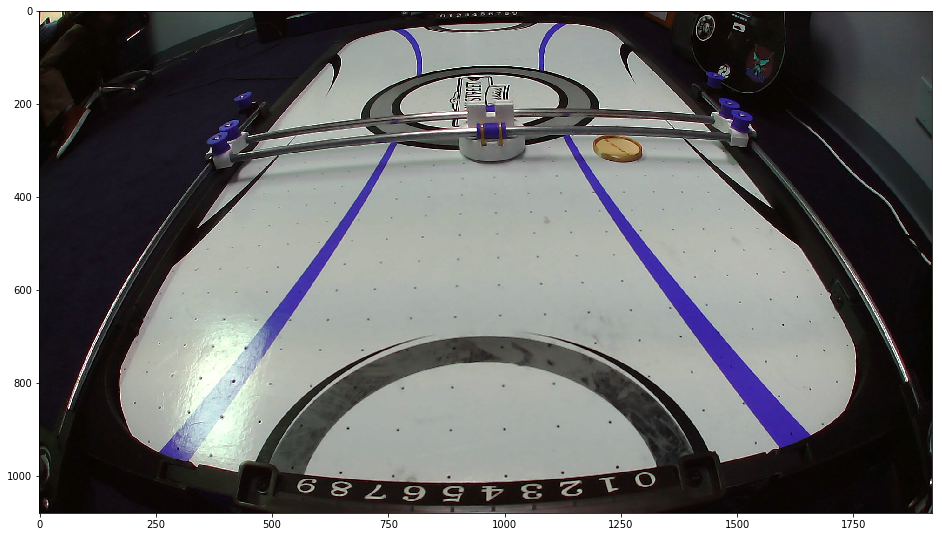

In [334]:
image=cv2.imread("Center_5.jpg")

orig = image.copy()

show_img(image)

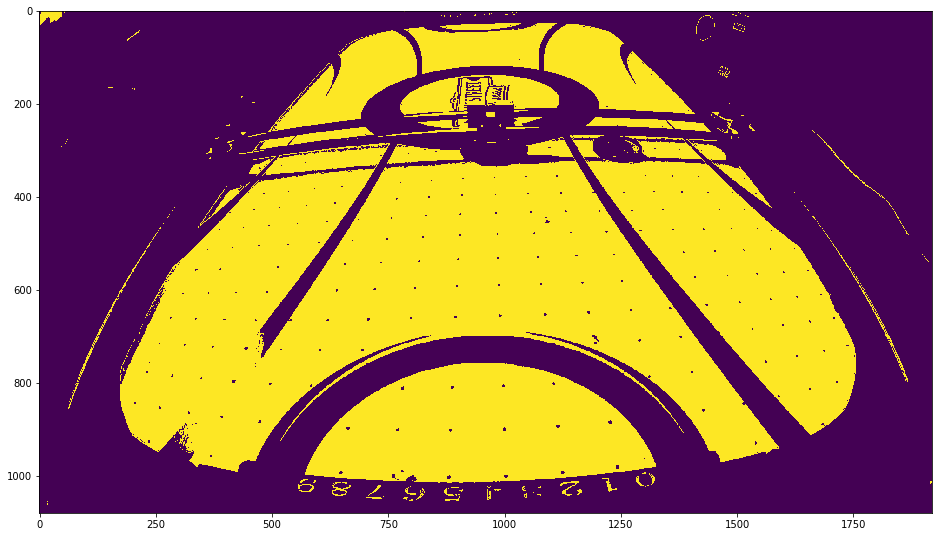

In [335]:
bw_img = get_bw_img(image)
show_img(bw_img)

In [336]:
clean_img = remove_noise(bw_img)
#show_img(clean_img)

In [337]:
# Find the contours from the cleaned image.
res_img, contours, hierarchy = cv2.findContours(clean_img.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [338]:
if (len(contours) > 10):
    print 'There are too many contours to be accurate!', len(contours)
    clean_img = remove_noise(bw_img, kernel_open=np.ones((1,65)))
    res_img, contours, hierarchy = cv2.findContours(clean_img.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [339]:
contour_points = get_contour_points(contours)

In [340]:
# returned shape starts with bottom-left and 3 other points are
# counter clockwise
board_shape=get_board_shape(contour_points)

In [341]:
#DRAW RESULTING SHAPE
disp_img=image.copy()
img = cv2.line(disp_img, tuple(board_shape[0]), tuple(board_shape[1]), (255,255,0), 5)
img = cv2.line(disp_img, tuple(board_shape[1]), tuple(board_shape[2]), (255,255,0), 5)
img = cv2.line(disp_img, tuple(board_shape[2]), tuple(board_shape[3]), (255,255,0), 5)
img = cv2.line(disp_img, tuple(board_shape[3]), tuple(board_shape[0]), (255,255,0), 5)

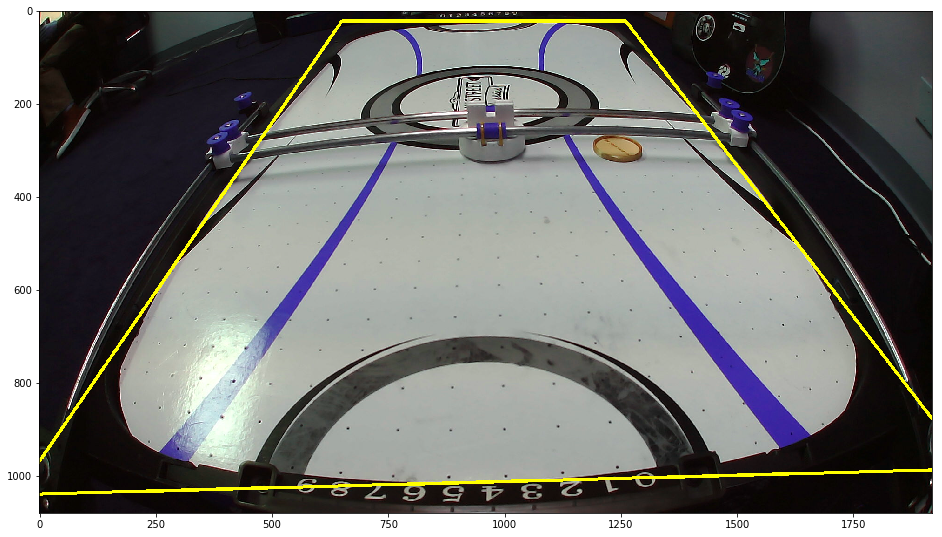

In [342]:
show_img(disp_img)

In [343]:
pts_src = np.array(
    [
        board_shape[0],
        board_shape[1],
        board_shape[2],
        board_shape[3]
    ]
)

pts_dst = np.array(
    [
        [0, 639],
        [479, 639],
        [479, 0],
        [0, 0]        
    ]
)

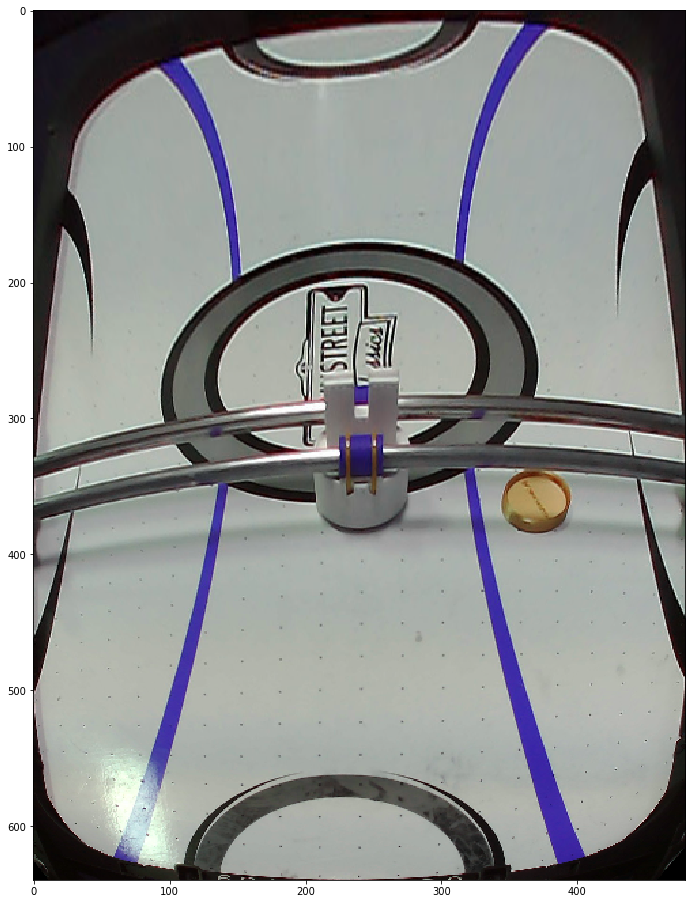

In [344]:
h, status = cv2.findHomography(pts_src, pts_dst)
warped = cv2.warpPerspective(image, h, (480, 640))

show_img(warped)